<a href="https://colab.research.google.com/github/poets-ai/elegy/blob/master/docs/getting-started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial we will explore the basic features of **Elegy**. If you are a Keras user you should feel at home, if you are currently using Jax things will appear much more streamlined. To get started you will first need to install the following dependencies:

In [ ]:
! pip install --upgrade pip
! pip install elegy dataget matplotlib
! pip install jax==0.1.75 jaxlib==0.1.52 # for CPU only
# For GPU install proper version of your CUDA, following will work in COLAB:
# ! pip install --upgrade jax==0.1.75 jaxlib==0.1.52+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

Note that Elegy doesn't depend on `jax` since there are both `cpu` and `gpu` versions you can choose from, the previous block will install `jax-cpu`, if you want jax to run on gpu you will need to [install it](https://github.com/google/jax#installation) separately. If you are running this example on Colab you need to uncomment the part which installs the GPU version suitable for Colab.

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need to download and load the data into memory. Here we will use `dataget` for simplicity but you can use you favorite datasets library.

In [1]:
import dataget

X_train, y_train, X_test, y_test = dataget.image.mnist(global_cache=True).get()

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

X_train: (60000, 28, 28) uint8
y_train: (60000,) uint8
X_test: (10000, 28, 28) uint8
y_test: (10000,) uint8


In this case `dataget` loads the data from Yann LeCun's website.

## Defining the Architecture
Now that we have the data we can define our model. In Elegy you can do this by inheriting from `elegy.Module` and defining a `call` method. This method should take in some inputs, perform a series of transformation using Jax, and returns the outputs of the network. In this example we will create a simple 2 layer MLP using Elegy modules: 

In [2]:
import jax.numpy as jnp
import jax

import elegy

class MLP(elegy.Module):
    """Standard LeNet-300-100 MLP network."""
    def __init__(self, n1: int = 300, n2: int = 100, **kwargs):
        super().__init__(**kwargs)
        self.n1 = n1
        self.n2 = n2
    
    def call(self, image: jnp.ndarray) -> jnp.ndarray:
        
        image = image.astype(jnp.float32) / 255.0
        
        mlp = elegy.nn.sequential(
            elegy.nn.Flatten(),
            elegy.nn.Linear(self.n1),
            jax.nn.relu,
            elegy.nn.Linear(self.n2),
            jax.nn.relu,
            elegy.nn.Linear(10),
        )
        
        return mlp(image)

Here we are using `sequential` to stack two layers with `relu` activations and a final `Linear` layer with `10` units that represents the logits of the network. This code should feel familiar to most Keras / PyTorch users. The main difference here is that thanks to elegy's [hooks system](https://poets-ai.github.io/elegy/guides/module-system/) you can (uncoditionally) declare modules, parameters, and states right in your `call` (forward) function without having to explicitly assign them to properties. This tends to produce much more readable code and reduce boilerplate.


## Creating the Model

Now that we have this module we can create an Elegy `Model`.

In [3]:
import optax

model = elegy.Model(
    module=MLP(n1=300, n2=100),
    loss=[
        elegy.losses.SparseCategoricalCrossentropy(from_logits=True),
        elegy.regularizers.GlobalL2(l=1e-4),
    ],
    metrics=elegy.metrics.SparseCategoricalAccuracy(),
    optimizer=optax.adam(1e-3),
)

Much like `keras.Model`, an Elegy Model is tasked with performing training, evaluation, and inference. The constructor of this class accepts most of the arguments accepted by `keras.Model.compile` as you might have seen but there are some notable differences:

1. It requires you to pass a `module` as first argument.
2. `loss` can be a list even if we don't have multiple corresponding outputs/labels, this is because Elegy exposes a more [flexible system](https://poets-ai.github.io/elegy/guides/modules-losses-metrics/) for defining losses and metrics based on Dependency Injection.

As in Keras, you can get a rich description of the model by calling `Model.summary` with a sample input:

In [4]:
model.summary(X_train[:64])


╒═════════════════════╤═══════════════════════╤═════════════════════╤═════════════════╕
│ Layer               │ Outputs Shape         │ Trainable           │   Non-trainable │
│                     │                       │ Parameters          │      Parameters │
╞═════════════════════╪═══════════════════════╪═════════════════════╪═════════════════╡
│ Inputs              │ (64, 28, 28)  uint8   │ 0                   │               0 │
├─────────────────────┼───────────────────────┼─────────────────────┼─────────────────┤
│ flatten   (Flatten) │ (64, 784)     float32 │ 0                   │               0 │
├─────────────────────┼───────────────────────┼─────────────────────┼─────────────────┤
│ linear    (Linear)  │ (64, 300)     float32 │ 235,500    942.0 KB │               0 │
├─────────────────────┼───────────────────────┼─────────────────────┼─────────────────┤
│ relu                │ (64, 300)     float32 │ 0                   │               0 │
├─────────────────────┼────────

## Training the Model
Having our `model` instance we are now ready to pass it some data to start training. Like in Keras this is done via the `fit` method which contains more or less the same signature. We try to be as compatible with Keras as possible but also remove a lot of the Tensorflow specific stuff. The following code will train our model for `100` epochs while limiting each epoch to `200` steps and using a batch size of `64`:

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[elegy.callbacks.ModelCheckpoint("model", save_best_only=True)],
)

```
...

Epoch 99/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0452 - loss: 0.0662 - sparse_categorical_accuracy: 0.9928 - sparse_categorical_crossentropy_loss: 0.0210 - val_l2_regularization_loss: 0.0451 - val_loss: 0.1259 - val_sparse_categorical_accuracy: 0.9766 - val_sparse_categorical_crossentropy_loss: 0.0808
Epoch 100/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0450 - loss: 0.0610 - sparse_categorical_accuracy: 0.9953 - sparse_categorical_crossentropy_loss: 0.0161 - val_l2_regularization_loss: 0.0447 - val_loss: 0.1093 - val_sparse_categorical_accuracy: 0.9795 - val_sparse_categorical_crossentropy_loss: 0.0646                         
```

As you see we've ported Keras progress bar and also implemented its `Callback` and `History` APIs. `fit` returns a `history` object which we will use next to visualize how the metrics and losses evolved during training.

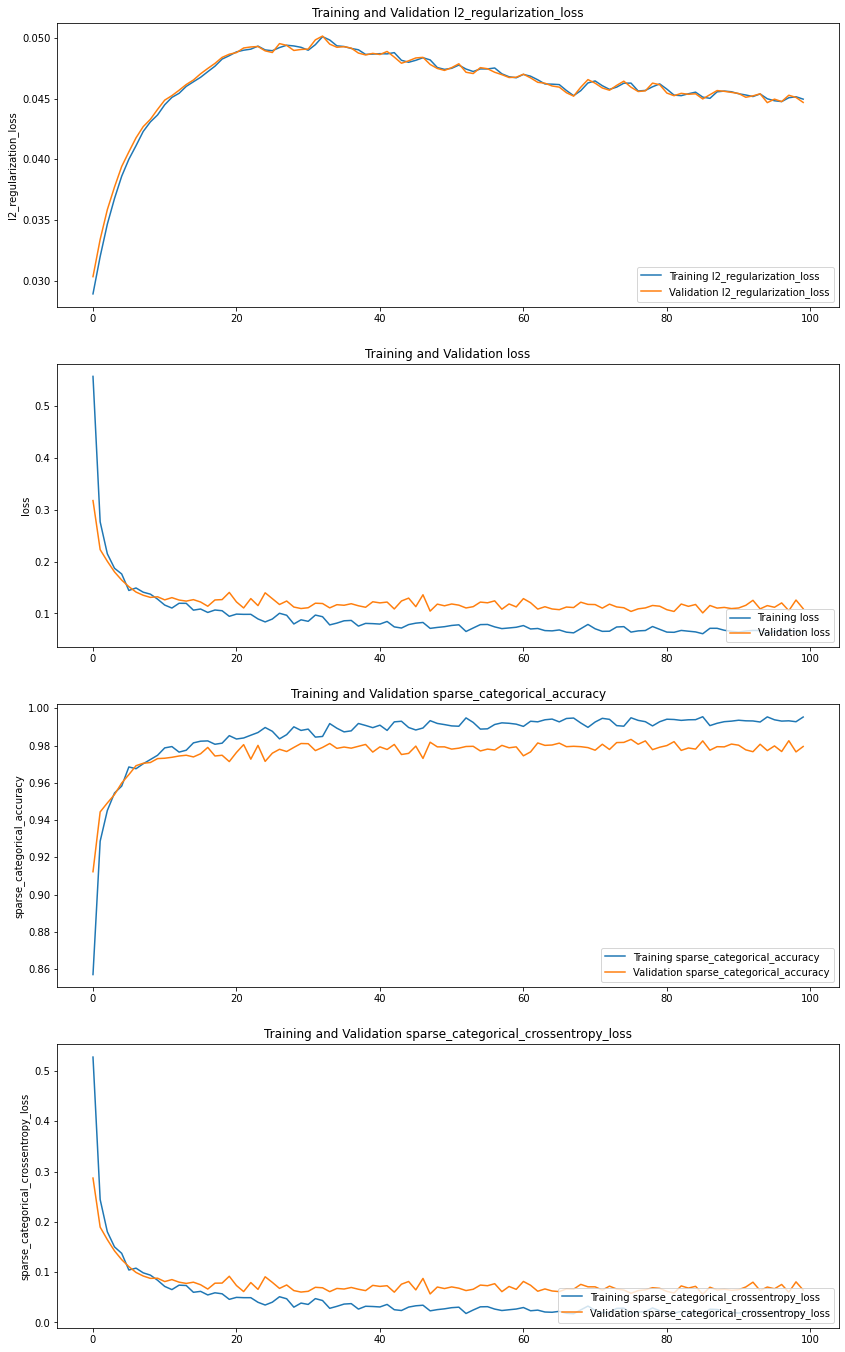

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

## Generating Predictions

Having our trained model we can now get some samples from the test set and generate some predictions. First we will just pick some random samples using `numpy`:

In [7]:
import numpy as np

idxs = np.random.randint(0, 10000, size=(9,))
x_sample = X_test[idxs]

Here we selected `9` random images. Now we can use the `predict` method to get their labels:

In [8]:
y_pred = model.predict(x=x_sample)

Easy right? Finally lets plot the results to see if they are accurate.

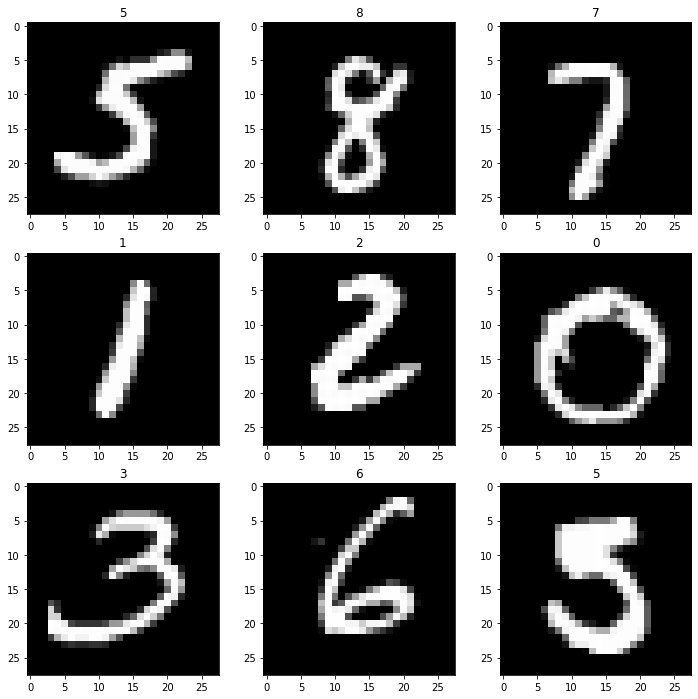

In [9]:
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")

Perfect!

## Serialization
To serialize the `Model` you can just use the `model.save(...)` method, this will create a folder with some files that contain the model's code plus all parameters and states. However, here we don't need to do that since we previously added the `elegy.callbacks.ModelCheckpoint` callback on `fit` which periodically does this for us during training. We configured `ModelCheckpoint` to save our model to a folder called `"model"` so we can just load it from there using `elegy.model.load`. Lets get a new model reference containing the same weights and call its `evaluate` method to verify everything loaded correctly:

In [10]:
# current model reference
print("current model id:", id(model))

# load model from disk
model = elegy.model.load("model")

# new model reference
print("new model id:    ", id(model))

# check that it works!
model.evaluate(x=X_test, y=y_test)

current model id: 140137340602160
new model id:     140136071352432


/data/cristian/elegy/.venv/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


313/313 [==============================] - 1s 3ms/step - l2_regularization_loss: 0.0450 - loss: 0.1013 - sparse_categorical_accuracy: 0.9825 - sparse_categorical_crossentropy_loss: 0.0563


{'l2_regularization_loss': array(0.04499801, dtype=float32),
 'loss': array(0.10126135, dtype=float32),
 'sparse_categorical_accuracy': array(0.9825001, dtype=float32),
 'sparse_categorical_crossentropy_loss': array(0.05626357, dtype=float32),
 'size': 32}

Excellent! We hope you've enjoyed this tutorial.

## Next Steps
Elegy is still in a very early stage, there are probably tons of bugs and missing features but we will get there. If you have some ideas or feedback on the current design we are eager to hear from you, feel free to open an issue.